### Урок 4. Алгоритм построения дерева решений

#### Используя файл Lesson_4_extended.ipynb (он в web4.zip в материалах):

#### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

#### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

*Вводные:*

In [1]:
import matplotlib.pyplot as plt
import random
import time

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
# генерация данных

classification_data, classification_labels = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2, 
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5
)

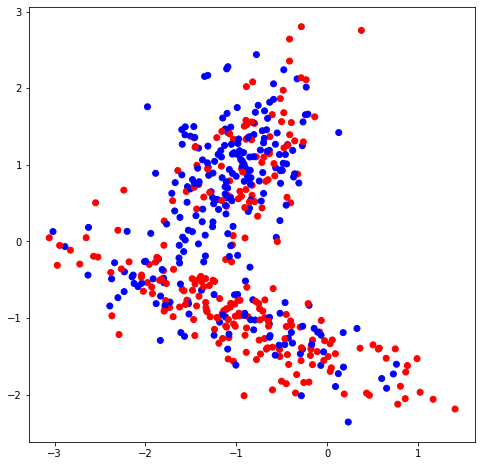

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)

#     print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= -0.46624201061399206
--> True:
  Индекс 0 <= -1.79696585158631
  --> True:
    Индекс 0 <= -1.9226384124885603
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Индекс 0 <= -1.1834902220493384
    --> True:
      Индекс 0 <= -1.6959366052924192
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 1 <= -1.2659561512192585
      --> True:
        Индекс 0 <= 0.7624451741809175
        --> True:
          Индекс 0 <= 0.04595444880264021
          --> True:
            Индекс 0 <= -0.2708916550945537
            --> True:
              Индекс 0 <= -0.3360165595341751
              --> True:
                Индекс 1 <= -1.4091570001288853
                --> True:
                  Индекс 0 <= -0.7776944655001441
                  --> True:
                    Прогноз: 0
                  --> False:
                    Прогноз: 0
                --> False:
                  Прогноз: 0
              --> F

In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

79.42857142857143

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

57.333333333333336

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

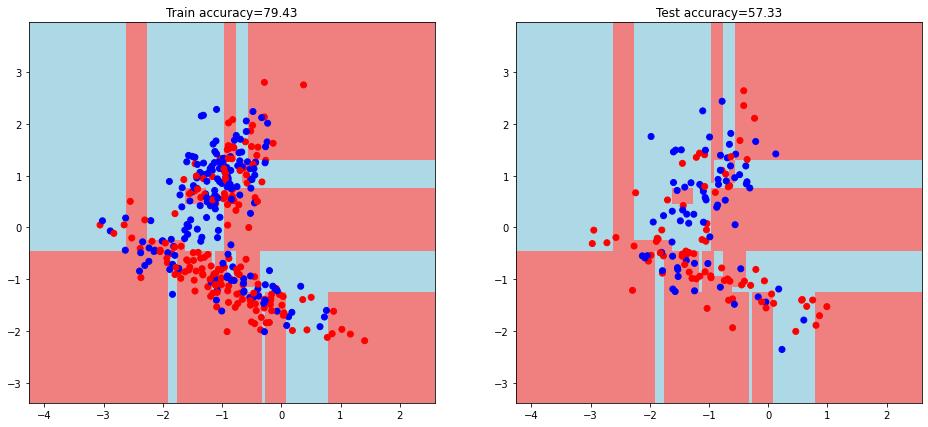

In [22]:
visualize(train_data, test_data)

#### Решение:

In [23]:
# вводим критерий останова по достижении заданной глубины дерева, с регулируемым количеством элементов в листе:

In [24]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле(если не задано, то равно единице)
    min_leaf = min_leaf if min_leaf else 1
    
    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [25]:
# Построение дерева с помощью рекурсивной функции, c ограничением глубины, и добавлением минимального количества элементов в листе:

def build_tree(data, labels, max_depth=None, min_leaf=None):
    
    # Если глубина не задана, будем строить по максимуму
    max_depth = max_depth if max_depth != None else data.shape[0]*data.shape[1]

    gain, t, index = find_best_split(data, labels, min_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или достигли максимальной глубины
    if gain == 0 or max_depth==0 :
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева, уменьшая их глубину
    true_branch = build_tree(true_data, true_labels,max_depth=max_depth-1,min_leaf=min_leaf)
    false_branch = build_tree(false_data, false_labels,max_depth=max_depth-1, min_leaf=min_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [26]:
# Построим дерево по обучающей выборке с указанной глубиной и мин. количеством объектов в узле
my_tree = build_tree(train_data, train_labels, max_depth=6, min_leaf=15)

In [27]:
print_tree(my_tree)

Индекс 1 <= -0.46624201061399206
--> True:
  Индекс 0 <= -1.7945477571816848
  --> True:
    Прогноз: 1
  --> False:
    Индекс 0 <= -1.1834902220493384
    --> True:
      Прогноз: 0
    --> False:
      Индекс 1 <= -1.2659561512192585
      --> True:
        Индекс 0 <= 0.04595444880264021
        --> True:
          Индекс 1 <= -1.4684500103378144
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0 <= -0.645018457805447
        --> True:
          Индекс 1 <= -0.9370288134393376
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 1
--> False:
  Индекс 0 <= -0.9820958539320116
  --> True:
    Индекс 0 <= -1.6445609784573159
    --> True:
      Индекс 0 <= -2.1808550952749775
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Индекс 1 <= 0.4215409934536155
      -->

In [28]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [29]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [30]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

72.57142857142857

In [31]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

60.66666666666667

*Уже видим небольшое улучшение качества модели*

Text(0.5, 1.0, 'Test accuracy=60.67')

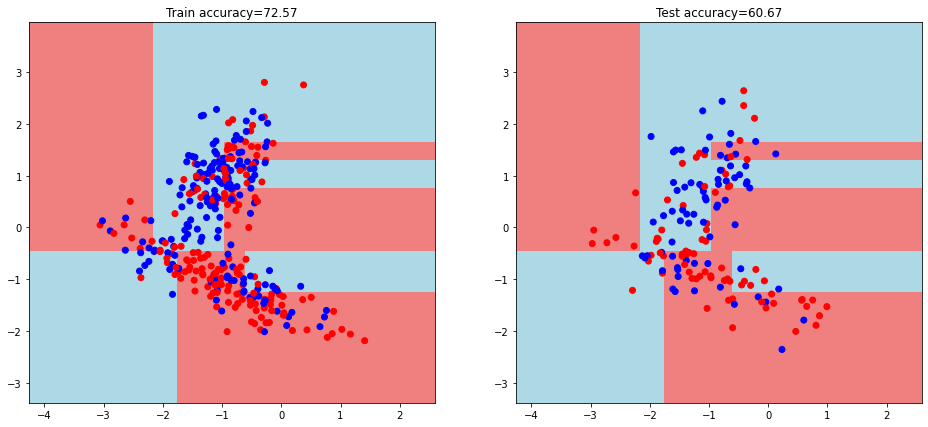

In [32]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')